### In this recipe you will learn how to calculate the Ocean Heat Content (OHC).

The equation to calculate OHC over depths is:

$\mathrm{OHC} = Cp \ \int_H^\eta T \ \rho \ dz$

where $Cp$ is the specific heat capacity of the seawater, $\rho$ is the density for every grid cell and $T$ is the water temperature.
As we are using ROMS, I will take Cp value from the mod_scalars.F in the model setup. There will also be an example onto how to calculate it integrating meridionally, zonally and by volume.

Notes:
 - You will use [XROMS](https://github.com/xoceanmodel/xroms) to help you select the depth
 - It is expected the user to have access to a ROMS output


Fernando Sobral - 27th Feb 2025

In [1]:
import xroms
import matplotlib.pyplot as plt


In [27]:
# Just to avoid a warning froms xroms
import warnings
warnings.filterwarnings('ignore')


# Reading roms data
ds = xroms.open_netcdf('data/roms_ex_data/outer_avg_01461.nc')
roms, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)

In [28]:
# When reading the data with xroms, you already have z_rho calculated. z_rho is the time-varying depths of the s-layers in meters.
# We will use this information to mask depths deeper than the chosen depth to calculate the OHC.
# Let's calculate the OHC for the 700 m depth.

z_rho = roms.z_rho
temp700 = roms.temp.where(z_rho >= -700)
rho700 = roms.rho.where(z_rho >= -700)


Text(0.5, 1.0, 'Temperature with depth')

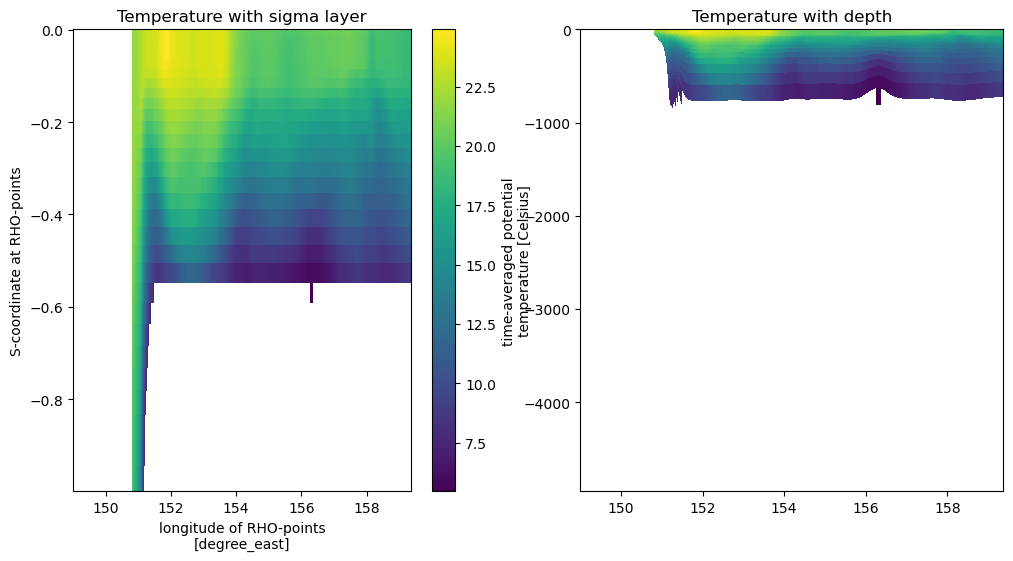

In [29]:
# Sanity check: plotting a zonal section to see if the mask is working

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

# Plotting temperature with sigma layer
temp700.isel(eta_rho=100, ocean_time=0).plot(ax=ax[0], x='lon_rho', y='s_rho')
ax[0].set_title('Temperature with sigma layer')

# Plotting temperature with depth
ax[1].pcolor(temp700.lon_rho.isel(eta_rho=100), z_rho.isel(eta_rho=100, ocean_time=0).values, temp700.isel(eta_rho=100, ocean_time=0).values)
ax[1].set_title('Temperature with depth')

In [30]:
# Now that we know the mask is working, let's calculate the OHC

# Getting Metrics: we will use dz
dz = roms.dz
dx = roms.dx
dy = roms.dy

# Got the values from ROMS from /g/data/fu5/trunk/ROMS/Modules/mod_scalars.F 
Cp = 3985  # Specific heat capacity of seawater in J/(kg·°C)


# Calculate the OHC: integrating vertically
ohc = (Cp * rho700 * temp700 * roms.dz).sum(dim='s_rho')


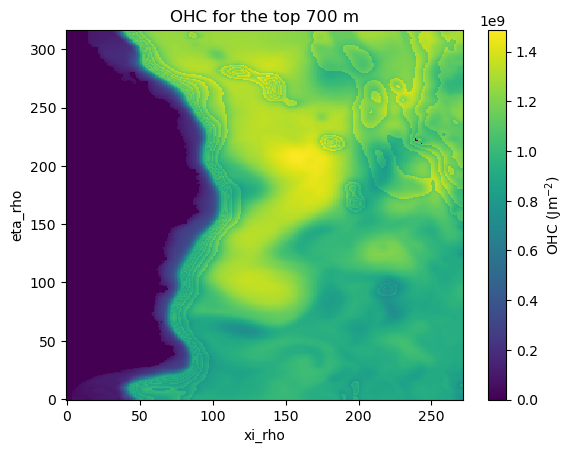

In [31]:
# Plotting OHC700 for one timestep

pt = ohc.isel(ocean_time=0).plot()
plt.title('OHC for the top 700 m')
pt.colorbar.set_label('OHC (Jm$^{-2}$)')

In [33]:
# You can also calculate the vertical integral directly from xroms 
ohc2 = xroms.gridsum(Cp * rho700 * temp700, xgrid, 'Z')

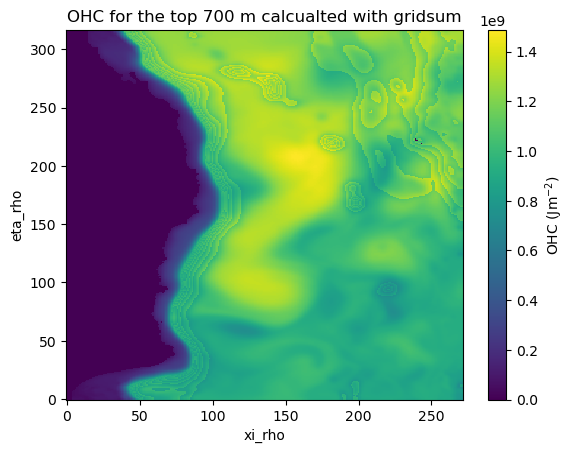

In [35]:
# Plotting to compare 

pt = ohc2.isel(ocean_time=0).plot()
plt.title('OHC for the top 700 m calcualted with gridsum')
pt.colorbar.set_label('OHC (Jm$^{-2}$)')

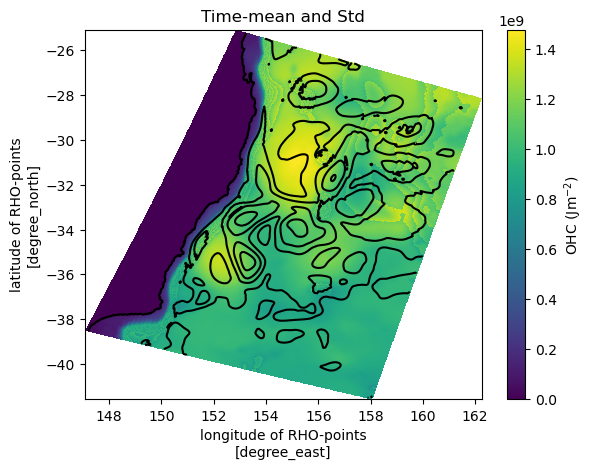

In [79]:
# Calculating the time-mean and std
ohc_mean = ohc.mean('ocean_time')
ohc_std = ohc.std('ocean_time')

pt = ohc_mean.plot(x='lon_rho', y='lat_rho')
ohc_std.plot.contour(x='lon_rho', y='lat_rho', colors='k')
plt.title('Time-mean and Std')
pt.colorbar.set_label('OHC (Jm$^{-2}$)')

In [ ]:
# If we want to calculate the mean zonal or meridional variation of the OHC we need to integrate both over depth and latitudes (dy) or longitudes (dx)

# Calculating without xroms since when doing for two dimensions it is clearner in this way.
ohc_meridional = (Cp * rho700 * temp700 * dx * dz).sum(['xi_rho', 's_rho']).mean('ocean_time')
ohc_zonal = (Cp * rho700 * temp700 * dy * dz).sum(['eta_rho', 's_rho']).mean('ocean_time')

Text(0.5, 1.0, 'Zonal OHC')

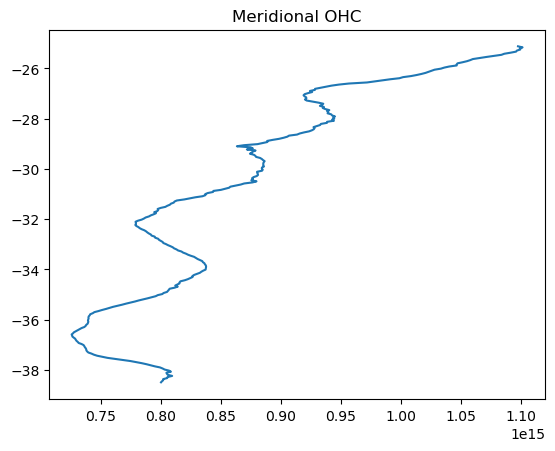

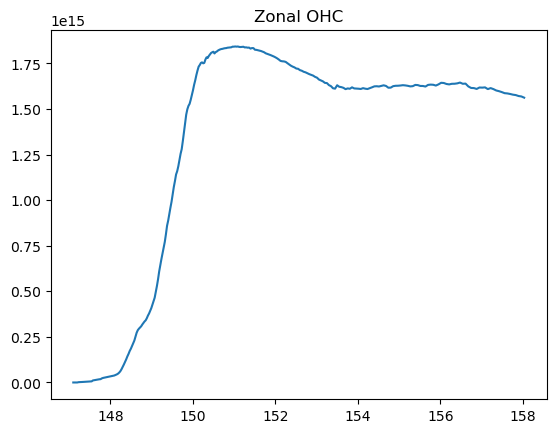

In [74]:
# To plot with latitude and longitude, since lat_rho and lon_rho are matrices, we will use the first column for latitudes and first row for longitudes as an approximation.

approx_lat = roms.lat_rho.isel(xi_rho=0)
approx_lon = roms.lon_rho.isel(eta_rho=0)

plt.figure()
plt.plot(ohc_meridional, approx_lat)
plt.title('Meridional OHC')

plt.figure()
plt.plot(approx_lon, ohc_zonal)
plt.title('Zonal OHC')

In [80]:
# And finally, doing a volume integral

ohc_volume = (Cp * rho700 * temp700 * dx * dy * dz).sum(['xi_rho', 'eta_rho', 's_rho'])

Text(0.5, 1.0, 'Volume integral for the OHC over time')

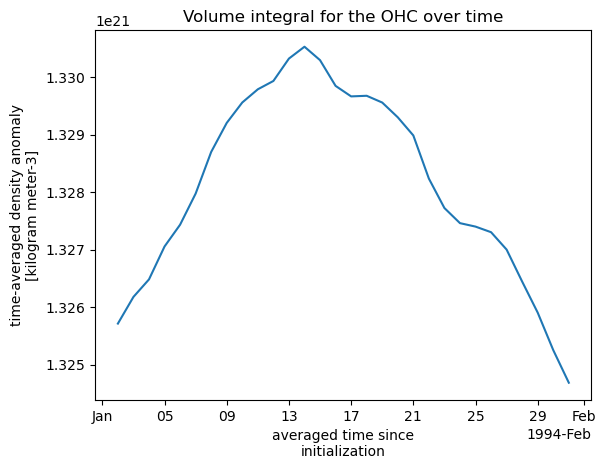

In [82]:
# Plotting

ohc_volume.plot()
plt.title('Volume integral for the OHC over time')